[View in Colaboratory](https://colab.research.google.com/github/sungreong/GAN/blob/master/WGAN_Keras_gpu(o)_mnist.ipynb)

In [0]:
from __future__ import print_function ,division

In [0]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape , Flatten , Dropout
from keras.layers import BatchNormalization, Activation ,ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

import keras.backend as K
import matplotlib.pyplot as plt

import sys

import numpy as np

import keras.backend.tensorflow_backend as K
import os



In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3513284834210694460
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11287966516
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17363116924762274192
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [0]:
class WGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        
        self.clip_value = 0.01
        
        optimizer = RMSprop(lr=0.00005)  ## 논문에서 추천?했던 걸로 알고 있음 

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=self.wasserstein_loss, 
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss=self.wasserstein_loss, optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss, 
            optimizer=optimizer,
            metrics=['accuracy'])

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        noise_shape = (100,)
        with K.tf.device('/gpu:0'):
            model = Sequential()

            model.add(Dense(128 * 7 * 7, activation="relu", input_shape=noise_shape))
            model.add(Reshape((7, 7, 128)))
            model.add(BatchNormalization(momentum=0.8))
            model.add(UpSampling2D())
            model.add(Conv2D(128, kernel_size=4, padding="same"))
            model.add(Activation("relu"))
            model.add(BatchNormalization(momentum=0.8))
            model.add(UpSampling2D())
            model.add(Conv2D(64, kernel_size=4, padding="same"))
            model.add(Activation("relu"))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Conv2D(1, kernel_size=4, padding="same"))
            model.add(Activation("tanh"))

            model.summary()

            noise = Input(shape=noise_shape)
            img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)
        with K.tf.device('/gpu:0'):
            model = Sequential()

            model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dropout(0.25))
            model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
            model.add(ZeroPadding2D(padding=((0,1),(0,1))))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dropout(0.25))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dropout(0.25))
            model.add(BatchNormalization(momentum=0.8))
            model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
            model.add(LeakyReLU(alpha=0.2))
            model.add(Dropout(0.25))

            model.add(Flatten())

            model.summary()

            img = Input(shape=img_shape)
            features = model(img)
            valid = Dense(1, activation="linear")(features)

        return Model(img, valid)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                #  Train Discriminator


                # Select a random half batch of images
                idx = np.random.randint(0, X_train.shape[0], half_batch)
                imgs = X_train[idx]

                noise = np.random.normal(0, 1, (half_batch, 100))

                # Generate a half batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the discriminator
                with K.tf.device('/gpu:0'):
                    d_loss_real = self.discriminator.train_on_batch(imgs, -np.ones((half_batch, 1)))
                    d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.ones((half_batch, 1)))
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip discriminator weights
                for l in self.discriminator.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)


   
            #  Train Generator
  

            noise = np.random.normal(0, 1, (batch_size, 100))

            # Train the generator
            with K.tf.device('/gpu:0'):
                for _ in range(3) : # 하드하게 generator 훈련시키기 
                    g_loss = self.combined.train_on_batch(noise, -np.ones((batch_size, 1)))

            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 1

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        if not os.path.exists("./images"):
            os.makedirs("./images")
        fig.savefig("./images/mnist_%d.png" % epoch)
        plt.close()




In [9]:
%%time
if __name__ == '__main__':
    wgan = WGAN()
    wgan.train(epochs=4000, batch_size=32, save_interval=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 14, 14, 16)        160       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7, 32)          4640      
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 8, 8, 32)          0         
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 8, 8, 32)          0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.999919] [G loss: 1.000163]
1 [D loss: 0.999918] [G loss: 1.000166]
2 [D loss: 0.999925] [G loss: 1.000152]
3 [D loss: 0.999934] [G loss: 1.000140]
4 [D loss: 0.999932] [G loss: 1.000132]
5 [D loss: 0.999934] [G loss: 1.000129]
6 [D loss: 0.999937] [G loss: 1.000134]
7 [D loss: 0.999924] [G loss: 1.000123]
8 [D loss: 0.999923] [G loss: 1.000131]
9 [D loss: 0.999933] [G loss: 1.000124]
10 [D loss: 0.999929] [G loss: 1.000133]
11 [D loss: 0.999927] [G loss: 1.000121]
12 [D loss: 0.999929] [G loss: 1.000126]
13 [D loss: 0.999937] [G loss: 1.000133]
14 [D loss: 0.999930] [G loss: 1.000118]
15 [D loss: 0.999935] [G loss: 1.000129]
16 [D loss: 0.999933] [G loss: 1.000116]
17 [D loss: 0.999930] [G loss: 1.000128]
18 [D loss: 0.999933] [G loss: 1.000112]
19 [D loss: 0.999933] [G loss: 1.000117]
20 [D loss: 0.999938] [G loss: 1.000129]
21 [D loss: 0.999935] [G loss: 1.000115]
22 [D loss: 0.999948] [G loss: 1.000112]
23 [D loss: 0.999949] [G loss: 1.000102]
24 [D loss: 0.999965] [G l

69 [D loss: 1.000137] [G loss: 1.000499]
70 [D loss: 1.000376] [G loss: 1.000525]
71 [D loss: 1.000309] [G loss: 1.000474]
72 [D loss: 1.000403] [G loss: 1.000541]
73 [D loss: 1.000296] [G loss: 1.000508]
74 [D loss: 1.000480] [G loss: 1.000691]
75 [D loss: 1.000330] [G loss: 1.000579]
76 [D loss: 1.000373] [G loss: 1.000656]
77 [D loss: 1.000410] [G loss: 1.000526]
78 [D loss: 1.000166] [G loss: 1.000670]
79 [D loss: 1.000340] [G loss: 1.000801]
80 [D loss: 1.000365] [G loss: 1.000734]
81 [D loss: 1.000365] [G loss: 1.000845]
82 [D loss: 1.000621] [G loss: 1.000794]
83 [D loss: 1.000436] [G loss: 1.000768]
84 [D loss: 1.000295] [G loss: 1.000744]
85 [D loss: 1.000503] [G loss: 1.000784]
86 [D loss: 1.000389] [G loss: 1.000898]
87 [D loss: 1.000365] [G loss: 1.000784]
88 [D loss: 1.000431] [G loss: 1.000820]
89 [D loss: 1.000557] [G loss: 1.000946]
90 [D loss: 1.000131] [G loss: 1.000837]
91 [D loss: 1.000415] [G loss: 1.000903]
92 [D loss: 1.000346] [G loss: 1.001012]
93 [D loss: 1.00

138 [D loss: 1.000443] [G loss: 1.002291]
139 [D loss: 1.000370] [G loss: 1.002359]
140 [D loss: 1.000188] [G loss: 1.002394]
141 [D loss: 0.999926] [G loss: 1.002515]
142 [D loss: 1.000235] [G loss: 1.002327]
143 [D loss: 1.000364] [G loss: 1.002456]
144 [D loss: 1.000222] [G loss: 1.002446]
145 [D loss: 1.000345] [G loss: 1.002474]
146 [D loss: 1.000162] [G loss: 1.002491]
147 [D loss: 1.000364] [G loss: 1.002525]
148 [D loss: 1.000181] [G loss: 1.002511]
149 [D loss: 1.000097] [G loss: 1.002227]
150 [D loss: 1.000280] [G loss: 1.002484]
151 [D loss: 1.000316] [G loss: 1.002492]
152 [D loss: 1.000169] [G loss: 1.002519]
153 [D loss: 1.000199] [G loss: 1.002602]
154 [D loss: 1.000081] [G loss: 1.002575]
155 [D loss: 1.000061] [G loss: 1.002499]
156 [D loss: 1.000357] [G loss: 1.002452]
157 [D loss: 1.000193] [G loss: 1.002476]
158 [D loss: 1.000401] [G loss: 1.002587]
159 [D loss: 1.000198] [G loss: 1.002461]
160 [D loss: 1.000249] [G loss: 1.002556]
161 [D loss: 1.000218] [G loss: 1.

206 [D loss: 0.999859] [G loss: 1.002480]
207 [D loss: 1.000012] [G loss: 1.002368]
208 [D loss: 1.000023] [G loss: 1.002605]
209 [D loss: 0.999981] [G loss: 1.002346]
210 [D loss: 1.000079] [G loss: 1.002416]
211 [D loss: 0.999971] [G loss: 1.002290]
212 [D loss: 0.999937] [G loss: 1.002361]
213 [D loss: 0.999876] [G loss: 1.002295]
214 [D loss: 0.999926] [G loss: 1.002271]
215 [D loss: 0.999991] [G loss: 1.002337]
216 [D loss: 0.999845] [G loss: 1.002231]
217 [D loss: 0.999804] [G loss: 1.002287]
218 [D loss: 0.999848] [G loss: 1.002187]
219 [D loss: 0.999804] [G loss: 1.002187]
220 [D loss: 1.000018] [G loss: 1.002188]
221 [D loss: 0.999925] [G loss: 1.002270]
222 [D loss: 0.999835] [G loss: 1.002104]
223 [D loss: 0.999925] [G loss: 1.002018]
224 [D loss: 1.000010] [G loss: 1.002050]
225 [D loss: 0.999930] [G loss: 1.002139]
226 [D loss: 0.999964] [G loss: 1.002196]
227 [D loss: 0.999941] [G loss: 1.002064]
228 [D loss: 0.999805] [G loss: 1.002019]
229 [D loss: 0.999873] [G loss: 1.

274 [D loss: 0.999948] [G loss: 1.000896]
275 [D loss: 0.999934] [G loss: 1.000847]
276 [D loss: 0.999895] [G loss: 1.000861]
277 [D loss: 0.999967] [G loss: 1.000751]
278 [D loss: 1.000005] [G loss: 1.000813]
279 [D loss: 0.999933] [G loss: 1.000799]
280 [D loss: 0.999939] [G loss: 1.000742]
281 [D loss: 0.999879] [G loss: 1.000783]
282 [D loss: 0.999918] [G loss: 1.000715]
283 [D loss: 0.999962] [G loss: 1.000673]
284 [D loss: 0.999974] [G loss: 1.000708]
285 [D loss: 0.999942] [G loss: 1.000638]
286 [D loss: 0.999985] [G loss: 1.000692]
287 [D loss: 0.999929] [G loss: 1.000664]
288 [D loss: 0.999960] [G loss: 1.000595]
289 [D loss: 0.999927] [G loss: 1.000694]
290 [D loss: 0.999981] [G loss: 1.000668]
291 [D loss: 0.999887] [G loss: 1.000601]
292 [D loss: 0.999948] [G loss: 1.000593]
293 [D loss: 0.999957] [G loss: 1.000644]
294 [D loss: 0.999934] [G loss: 1.000588]
295 [D loss: 0.999943] [G loss: 1.000525]
296 [D loss: 0.999923] [G loss: 1.000563]
297 [D loss: 0.999967] [G loss: 1.

342 [D loss: 0.999960] [G loss: 1.000197]
343 [D loss: 0.999938] [G loss: 1.000218]
344 [D loss: 0.999936] [G loss: 1.000206]
345 [D loss: 0.999941] [G loss: 1.000182]
346 [D loss: 0.999941] [G loss: 1.000173]
347 [D loss: 0.999957] [G loss: 1.000185]
348 [D loss: 0.999977] [G loss: 1.000202]
349 [D loss: 0.999961] [G loss: 1.000186]
350 [D loss: 0.999964] [G loss: 1.000168]
351 [D loss: 0.999946] [G loss: 1.000163]
352 [D loss: 0.999955] [G loss: 1.000160]
353 [D loss: 0.999950] [G loss: 1.000191]
354 [D loss: 0.999963] [G loss: 1.000173]
355 [D loss: 0.999937] [G loss: 1.000172]
356 [D loss: 0.999972] [G loss: 1.000164]
357 [D loss: 0.999965] [G loss: 1.000171]
358 [D loss: 0.999977] [G loss: 1.000132]
359 [D loss: 0.999960] [G loss: 1.000142]
360 [D loss: 0.999976] [G loss: 1.000160]
361 [D loss: 0.999941] [G loss: 1.000150]
362 [D loss: 0.999968] [G loss: 1.000152]
363 [D loss: 0.999957] [G loss: 1.000142]
364 [D loss: 0.999951] [G loss: 1.000165]
365 [D loss: 0.999996] [G loss: 1.

410 [D loss: 0.999959] [G loss: 1.000090]
411 [D loss: 0.999974] [G loss: 1.000080]
412 [D loss: 0.999980] [G loss: 1.000101]
413 [D loss: 0.999997] [G loss: 1.000119]
414 [D loss: 0.999975] [G loss: 1.000084]
415 [D loss: 0.999970] [G loss: 1.000089]
416 [D loss: 0.999958] [G loss: 1.000038]
417 [D loss: 0.999957] [G loss: 1.000074]
418 [D loss: 0.999973] [G loss: 1.000119]
419 [D loss: 0.999947] [G loss: 1.000110]
420 [D loss: 0.999961] [G loss: 1.000091]
421 [D loss: 0.999942] [G loss: 1.000118]
422 [D loss: 0.999952] [G loss: 1.000106]
423 [D loss: 0.999968] [G loss: 1.000141]
424 [D loss: 0.999970] [G loss: 1.000100]
425 [D loss: 0.999994] [G loss: 1.000096]
426 [D loss: 0.999978] [G loss: 1.000100]
427 [D loss: 0.999963] [G loss: 1.000061]
428 [D loss: 0.999967] [G loss: 1.000104]
429 [D loss: 0.999969] [G loss: 1.000128]
430 [D loss: 0.999951] [G loss: 1.000084]
431 [D loss: 0.999956] [G loss: 1.000081]
432 [D loss: 0.999985] [G loss: 1.000079]
433 [D loss: 0.999980] [G loss: 1.

478 [D loss: 0.999968] [G loss: 1.000085]
479 [D loss: 0.999968] [G loss: 1.000046]
480 [D loss: 0.999979] [G loss: 1.000083]
481 [D loss: 0.999949] [G loss: 1.000045]
482 [D loss: 0.999949] [G loss: 1.000081]
483 [D loss: 0.999951] [G loss: 1.000071]
484 [D loss: 0.999955] [G loss: 1.000094]
485 [D loss: 0.999976] [G loss: 1.000056]
486 [D loss: 0.999976] [G loss: 1.000079]
487 [D loss: 0.999985] [G loss: 1.000045]
488 [D loss: 0.999977] [G loss: 1.000080]
489 [D loss: 0.999958] [G loss: 1.000079]
490 [D loss: 0.999979] [G loss: 1.000066]
491 [D loss: 0.999947] [G loss: 1.000033]
492 [D loss: 0.999944] [G loss: 1.000067]
493 [D loss: 0.999954] [G loss: 1.000082]
494 [D loss: 0.999966] [G loss: 1.000058]
495 [D loss: 0.999981] [G loss: 1.000013]
496 [D loss: 0.999947] [G loss: 1.000086]
497 [D loss: 0.999956] [G loss: 1.000083]
498 [D loss: 0.999975] [G loss: 1.000070]
499 [D loss: 0.999964] [G loss: 1.000070]
500 [D loss: 0.999985] [G loss: 1.000068]
501 [D loss: 0.999936] [G loss: 1.

546 [D loss: 0.999960] [G loss: 1.000044]
547 [D loss: 0.999963] [G loss: 1.000047]
548 [D loss: 0.999937] [G loss: 1.000069]
549 [D loss: 0.999955] [G loss: 1.000082]
550 [D loss: 0.999964] [G loss: 1.000069]
551 [D loss: 0.999965] [G loss: 1.000088]
552 [D loss: 0.999963] [G loss: 1.000034]
553 [D loss: 0.999983] [G loss: 1.000053]
554 [D loss: 0.999945] [G loss: 1.000075]
555 [D loss: 0.999970] [G loss: 1.000067]
556 [D loss: 0.999946] [G loss: 1.000085]
557 [D loss: 0.999967] [G loss: 1.000073]
558 [D loss: 0.999966] [G loss: 1.000055]
559 [D loss: 0.999962] [G loss: 1.000070]
560 [D loss: 0.999981] [G loss: 1.000068]
561 [D loss: 0.999987] [G loss: 1.000093]
562 [D loss: 0.999965] [G loss: 1.000060]
563 [D loss: 0.999952] [G loss: 1.000061]
564 [D loss: 0.999956] [G loss: 1.000070]
565 [D loss: 0.999965] [G loss: 1.000040]
566 [D loss: 0.999975] [G loss: 1.000075]
567 [D loss: 0.999999] [G loss: 1.000081]
568 [D loss: 0.999966] [G loss: 1.000045]
569 [D loss: 0.999932] [G loss: 1.

614 [D loss: 0.999970] [G loss: 1.000071]
615 [D loss: 0.999936] [G loss: 1.000085]
616 [D loss: 0.999953] [G loss: 1.000076]
617 [D loss: 0.999949] [G loss: 1.000080]
618 [D loss: 0.999991] [G loss: 1.000103]
619 [D loss: 0.999964] [G loss: 1.000080]
620 [D loss: 0.999987] [G loss: 1.000054]
621 [D loss: 0.999952] [G loss: 1.000059]
622 [D loss: 0.999971] [G loss: 1.000092]
623 [D loss: 0.999962] [G loss: 1.000065]
624 [D loss: 0.999947] [G loss: 1.000084]
625 [D loss: 0.999984] [G loss: 1.000079]
626 [D loss: 0.999973] [G loss: 1.000030]
627 [D loss: 0.999941] [G loss: 1.000078]
628 [D loss: 0.999945] [G loss: 1.000090]
629 [D loss: 0.999964] [G loss: 1.000072]
630 [D loss: 0.999980] [G loss: 1.000050]
631 [D loss: 0.999964] [G loss: 1.000064]
632 [D loss: 0.999966] [G loss: 1.000045]
633 [D loss: 0.999968] [G loss: 1.000062]
634 [D loss: 0.999953] [G loss: 1.000074]
635 [D loss: 0.999969] [G loss: 1.000079]
636 [D loss: 0.999940] [G loss: 1.000065]
637 [D loss: 0.999968] [G loss: 1.

682 [D loss: 0.999958] [G loss: 1.000045]
683 [D loss: 0.999961] [G loss: 1.000065]
684 [D loss: 0.999971] [G loss: 1.000061]
685 [D loss: 0.999975] [G loss: 1.000088]
686 [D loss: 0.999951] [G loss: 1.000049]
687 [D loss: 0.999955] [G loss: 1.000040]
688 [D loss: 0.999956] [G loss: 1.000060]
689 [D loss: 0.999959] [G loss: 1.000047]
690 [D loss: 0.999980] [G loss: 1.000053]
691 [D loss: 0.999985] [G loss: 1.000064]
692 [D loss: 0.999967] [G loss: 1.000062]
693 [D loss: 0.999969] [G loss: 1.000047]
694 [D loss: 0.999987] [G loss: 1.000056]
695 [D loss: 0.999986] [G loss: 1.000057]
696 [D loss: 0.999973] [G loss: 1.000063]
697 [D loss: 0.999966] [G loss: 1.000042]
698 [D loss: 0.999950] [G loss: 1.000058]
699 [D loss: 0.999990] [G loss: 1.000062]
700 [D loss: 1.000004] [G loss: 1.000097]
701 [D loss: 0.999928] [G loss: 1.000033]
702 [D loss: 0.999997] [G loss: 1.000034]
703 [D loss: 0.999981] [G loss: 1.000074]
704 [D loss: 0.999926] [G loss: 1.000057]
705 [D loss: 1.000004] [G loss: 1.

750 [D loss: 0.999990] [G loss: 1.000091]
751 [D loss: 0.999963] [G loss: 1.000095]
752 [D loss: 0.999985] [G loss: 1.000052]
753 [D loss: 0.999963] [G loss: 1.000077]
754 [D loss: 0.999993] [G loss: 1.000098]
755 [D loss: 0.999952] [G loss: 1.000063]
756 [D loss: 0.999996] [G loss: 1.000058]
757 [D loss: 0.999947] [G loss: 1.000054]
758 [D loss: 0.999937] [G loss: 1.000085]
759 [D loss: 0.999972] [G loss: 1.000097]
760 [D loss: 0.999966] [G loss: 1.000079]
761 [D loss: 1.000019] [G loss: 1.000085]
762 [D loss: 0.999957] [G loss: 1.000091]
763 [D loss: 0.999989] [G loss: 1.000092]
764 [D loss: 0.999946] [G loss: 1.000072]
765 [D loss: 0.999970] [G loss: 1.000080]
766 [D loss: 0.999958] [G loss: 1.000044]
767 [D loss: 0.999955] [G loss: 1.000079]
768 [D loss: 1.000013] [G loss: 1.000075]
769 [D loss: 0.999971] [G loss: 1.000127]
770 [D loss: 0.999934] [G loss: 1.000062]
771 [D loss: 0.999964] [G loss: 1.000044]
772 [D loss: 0.999957] [G loss: 1.000060]
773 [D loss: 0.999945] [G loss: 1.

818 [D loss: 0.999934] [G loss: 1.000093]
819 [D loss: 0.999966] [G loss: 1.000078]
820 [D loss: 0.999921] [G loss: 1.000076]
821 [D loss: 0.999976] [G loss: 1.000080]
822 [D loss: 0.999979] [G loss: 1.000096]
823 [D loss: 0.999984] [G loss: 1.000055]
824 [D loss: 0.999956] [G loss: 1.000074]
825 [D loss: 0.999952] [G loss: 1.000051]
826 [D loss: 0.999981] [G loss: 1.000037]
827 [D loss: 0.999959] [G loss: 1.000066]
828 [D loss: 0.999995] [G loss: 1.000118]
829 [D loss: 0.999971] [G loss: 1.000067]
830 [D loss: 0.999975] [G loss: 1.000051]
831 [D loss: 0.999942] [G loss: 1.000097]
832 [D loss: 0.999943] [G loss: 1.000020]
833 [D loss: 0.999953] [G loss: 1.000054]
834 [D loss: 0.999974] [G loss: 1.000071]
835 [D loss: 0.999943] [G loss: 1.000083]
836 [D loss: 0.999983] [G loss: 1.000083]
837 [D loss: 0.999992] [G loss: 1.000040]
838 [D loss: 0.999954] [G loss: 1.000031]
839 [D loss: 0.999970] [G loss: 1.000088]
840 [D loss: 0.999974] [G loss: 1.000106]
841 [D loss: 0.999936] [G loss: 1.

886 [D loss: 0.999987] [G loss: 1.000037]
887 [D loss: 0.999968] [G loss: 1.000043]
888 [D loss: 0.999960] [G loss: 1.000088]
889 [D loss: 0.999969] [G loss: 1.000067]
890 [D loss: 0.999970] [G loss: 1.000080]
891 [D loss: 0.999982] [G loss: 1.000038]
892 [D loss: 0.999974] [G loss: 1.000104]
893 [D loss: 0.999950] [G loss: 1.000093]
894 [D loss: 0.999980] [G loss: 1.000065]
895 [D loss: 0.999967] [G loss: 1.000063]
896 [D loss: 0.999948] [G loss: 1.000064]
897 [D loss: 0.999939] [G loss: 1.000060]
898 [D loss: 0.999968] [G loss: 1.000089]
899 [D loss: 0.999959] [G loss: 1.000074]
900 [D loss: 0.999969] [G loss: 1.000082]
901 [D loss: 0.999989] [G loss: 1.000009]
902 [D loss: 0.999970] [G loss: 1.000061]
903 [D loss: 0.999948] [G loss: 1.000048]
904 [D loss: 0.999953] [G loss: 1.000090]
905 [D loss: 0.999959] [G loss: 1.000080]
906 [D loss: 0.999948] [G loss: 1.000091]
907 [D loss: 0.999960] [G loss: 1.000043]
908 [D loss: 0.999959] [G loss: 1.000058]
909 [D loss: 0.999942] [G loss: 1.

954 [D loss: 0.999911] [G loss: 1.000068]
955 [D loss: 0.999936] [G loss: 1.000060]
956 [D loss: 0.999974] [G loss: 1.000032]
957 [D loss: 1.000003] [G loss: 1.000046]
958 [D loss: 0.999993] [G loss: 1.000067]
959 [D loss: 0.999972] [G loss: 1.000073]
960 [D loss: 0.999978] [G loss: 1.000076]
961 [D loss: 0.999954] [G loss: 1.000091]
962 [D loss: 0.999982] [G loss: 1.000082]
963 [D loss: 0.999984] [G loss: 1.000103]
964 [D loss: 0.999971] [G loss: 1.000097]
965 [D loss: 0.999957] [G loss: 1.000075]
966 [D loss: 0.999939] [G loss: 1.000066]
967 [D loss: 0.999945] [G loss: 1.000085]
968 [D loss: 0.999949] [G loss: 1.000075]
969 [D loss: 0.999963] [G loss: 1.000042]
970 [D loss: 0.999999] [G loss: 1.000034]
971 [D loss: 1.000026] [G loss: 1.000072]
972 [D loss: 1.000008] [G loss: 1.000080]
973 [D loss: 0.999969] [G loss: 1.000086]
974 [D loss: 0.999998] [G loss: 1.000102]
975 [D loss: 0.999993] [G loss: 1.000061]
976 [D loss: 0.999949] [G loss: 1.000059]
977 [D loss: 0.999988] [G loss: 1.

1022 [D loss: 0.999978] [G loss: 1.000060]
1023 [D loss: 0.999970] [G loss: 1.000050]
1024 [D loss: 0.999999] [G loss: 1.000059]
1025 [D loss: 0.999965] [G loss: 1.000058]
1026 [D loss: 0.999983] [G loss: 1.000045]
1027 [D loss: 0.999945] [G loss: 1.000074]
1028 [D loss: 1.000002] [G loss: 1.000025]
1029 [D loss: 0.999945] [G loss: 1.000085]
1030 [D loss: 0.999970] [G loss: 1.000070]
1031 [D loss: 0.999987] [G loss: 1.000037]
1032 [D loss: 0.999968] [G loss: 1.000070]
1033 [D loss: 0.999944] [G loss: 1.000042]
1034 [D loss: 0.999989] [G loss: 1.000084]
1035 [D loss: 0.999964] [G loss: 1.000057]
1036 [D loss: 0.999986] [G loss: 1.000089]
1037 [D loss: 0.999964] [G loss: 1.000078]
1038 [D loss: 0.999946] [G loss: 1.000073]
1039 [D loss: 0.999954] [G loss: 1.000072]
1040 [D loss: 0.999986] [G loss: 1.000079]
1041 [D loss: 0.999944] [G loss: 1.000091]
1042 [D loss: 0.999994] [G loss: 1.000071]
1043 [D loss: 0.999936] [G loss: 1.000058]
1044 [D loss: 0.999991] [G loss: 1.000029]
1045 [D los

1089 [D loss: 0.999930] [G loss: 1.000057]
1090 [D loss: 0.999961] [G loss: 1.000075]
1091 [D loss: 0.999948] [G loss: 1.000055]
1092 [D loss: 0.999978] [G loss: 1.000034]
1093 [D loss: 0.999998] [G loss: 1.000071]
1094 [D loss: 0.999982] [G loss: 1.000087]
1095 [D loss: 0.999936] [G loss: 1.000055]
1096 [D loss: 0.999954] [G loss: 1.000044]
1097 [D loss: 0.999965] [G loss: 1.000040]
1098 [D loss: 0.999941] [G loss: 1.000075]
1099 [D loss: 0.999976] [G loss: 1.000069]
1100 [D loss: 0.999937] [G loss: 1.000099]
1101 [D loss: 0.999938] [G loss: 1.000062]
1102 [D loss: 0.999997] [G loss: 1.000080]
1103 [D loss: 0.999940] [G loss: 1.000090]
1104 [D loss: 0.999988] [G loss: 1.000100]
1105 [D loss: 0.999957] [G loss: 1.000080]
1106 [D loss: 0.999933] [G loss: 1.000109]
1107 [D loss: 0.999952] [G loss: 1.000053]
1108 [D loss: 0.999958] [G loss: 1.000077]
1109 [D loss: 0.999991] [G loss: 1.000044]
1110 [D loss: 0.999954] [G loss: 1.000057]
1111 [D loss: 0.999973] [G loss: 1.000081]
1112 [D los

1156 [D loss: 0.999957] [G loss: 1.000058]
1157 [D loss: 0.999964] [G loss: 1.000074]
1158 [D loss: 0.999990] [G loss: 1.000047]
1159 [D loss: 0.999961] [G loss: 1.000099]
1160 [D loss: 0.999979] [G loss: 1.000084]
1161 [D loss: 0.999952] [G loss: 1.000057]
1162 [D loss: 0.999957] [G loss: 1.000068]
1163 [D loss: 0.999958] [G loss: 1.000057]
1164 [D loss: 0.999969] [G loss: 1.000107]
1165 [D loss: 0.999949] [G loss: 1.000039]
1166 [D loss: 0.999974] [G loss: 1.000051]
1167 [D loss: 0.999981] [G loss: 1.000089]
1168 [D loss: 0.999990] [G loss: 1.000057]
1169 [D loss: 0.999965] [G loss: 1.000083]
1170 [D loss: 0.999974] [G loss: 1.000049]
1171 [D loss: 0.999963] [G loss: 1.000092]
1172 [D loss: 0.999940] [G loss: 1.000108]
1173 [D loss: 0.999951] [G loss: 1.000082]
1174 [D loss: 0.999963] [G loss: 1.000122]
1175 [D loss: 1.000000] [G loss: 1.000094]
1176 [D loss: 0.999984] [G loss: 1.000024]
1177 [D loss: 0.999991] [G loss: 1.000075]
1178 [D loss: 0.999982] [G loss: 1.000068]
1179 [D los

1223 [D loss: 0.999974] [G loss: 1.000078]
1224 [D loss: 0.999946] [G loss: 1.000099]
1225 [D loss: 0.999997] [G loss: 1.000060]
1226 [D loss: 0.999954] [G loss: 1.000103]
1227 [D loss: 0.999972] [G loss: 1.000087]
1228 [D loss: 0.999950] [G loss: 1.000057]
1229 [D loss: 0.999972] [G loss: 1.000108]
1230 [D loss: 0.999963] [G loss: 1.000089]
1231 [D loss: 0.999950] [G loss: 1.000079]
1232 [D loss: 0.999974] [G loss: 1.000052]
1233 [D loss: 0.999972] [G loss: 1.000091]
1234 [D loss: 0.999981] [G loss: 1.000084]
1235 [D loss: 0.999930] [G loss: 1.000082]
1236 [D loss: 0.999967] [G loss: 1.000051]
1237 [D loss: 0.999959] [G loss: 1.000100]
1238 [D loss: 0.999944] [G loss: 1.000039]
1239 [D loss: 0.999963] [G loss: 1.000056]
1240 [D loss: 0.999997] [G loss: 1.000079]
1241 [D loss: 0.999973] [G loss: 1.000076]
1242 [D loss: 0.999970] [G loss: 1.000088]
1243 [D loss: 0.999937] [G loss: 1.000071]
1244 [D loss: 0.999976] [G loss: 1.000046]
1245 [D loss: 0.999968] [G loss: 1.000052]
1246 [D los

1290 [D loss: 0.999965] [G loss: 1.000042]
1291 [D loss: 0.999972] [G loss: 1.000096]
1292 [D loss: 0.999987] [G loss: 1.000096]
1293 [D loss: 0.999937] [G loss: 1.000065]
1294 [D loss: 0.999961] [G loss: 1.000047]
1295 [D loss: 0.999964] [G loss: 1.000080]
1296 [D loss: 0.999952] [G loss: 1.000068]
1297 [D loss: 1.000017] [G loss: 1.000050]
1298 [D loss: 0.999946] [G loss: 1.000079]
1299 [D loss: 0.999939] [G loss: 1.000041]
1300 [D loss: 0.999980] [G loss: 1.000065]
1301 [D loss: 0.999952] [G loss: 1.000047]
1302 [D loss: 0.999957] [G loss: 1.000087]
1303 [D loss: 0.999951] [G loss: 1.000081]
1304 [D loss: 0.999953] [G loss: 1.000066]
1305 [D loss: 0.999973] [G loss: 1.000068]
1306 [D loss: 0.999937] [G loss: 1.000065]
1307 [D loss: 0.999995] [G loss: 1.000046]
1308 [D loss: 0.999974] [G loss: 1.000071]
1309 [D loss: 0.999953] [G loss: 1.000061]
1310 [D loss: 1.000008] [G loss: 1.000107]
1311 [D loss: 0.999975] [G loss: 1.000077]
1312 [D loss: 0.999973] [G loss: 1.000041]
1313 [D los

1357 [D loss: 0.999948] [G loss: 1.000064]
1358 [D loss: 0.999991] [G loss: 1.000092]
1359 [D loss: 0.999987] [G loss: 1.000059]
1360 [D loss: 0.999987] [G loss: 1.000084]
1361 [D loss: 0.999935] [G loss: 1.000067]
1362 [D loss: 0.999988] [G loss: 1.000040]
1363 [D loss: 0.999954] [G loss: 1.000075]
1364 [D loss: 0.999986] [G loss: 1.000085]
1365 [D loss: 0.999976] [G loss: 1.000084]
1366 [D loss: 0.999975] [G loss: 1.000068]
1367 [D loss: 0.999951] [G loss: 1.000058]
1368 [D loss: 0.999963] [G loss: 1.000060]
1369 [D loss: 0.999981] [G loss: 1.000060]
1370 [D loss: 0.999956] [G loss: 1.000088]
1371 [D loss: 0.999953] [G loss: 1.000096]
1372 [D loss: 0.999967] [G loss: 1.000068]
1373 [D loss: 0.999964] [G loss: 1.000071]
1374 [D loss: 0.999983] [G loss: 1.000086]
1375 [D loss: 0.999972] [G loss: 1.000077]
1376 [D loss: 0.999986] [G loss: 1.000061]
1377 [D loss: 0.999932] [G loss: 1.000087]
1378 [D loss: 0.999957] [G loss: 1.000095]
1379 [D loss: 0.999984] [G loss: 1.000090]
1380 [D los

1424 [D loss: 0.999979] [G loss: 1.000083]
1425 [D loss: 0.999955] [G loss: 1.000109]
1426 [D loss: 0.999963] [G loss: 1.000077]
1427 [D loss: 0.999912] [G loss: 1.000067]
1428 [D loss: 0.999988] [G loss: 1.000080]
1429 [D loss: 0.999985] [G loss: 1.000094]
1430 [D loss: 0.999975] [G loss: 1.000092]
1431 [D loss: 0.999977] [G loss: 1.000046]
1432 [D loss: 0.999946] [G loss: 1.000064]
1433 [D loss: 0.999930] [G loss: 1.000077]
1434 [D loss: 0.999936] [G loss: 1.000075]
1435 [D loss: 0.999952] [G loss: 1.000060]
1436 [D loss: 0.999984] [G loss: 1.000087]
1437 [D loss: 0.999927] [G loss: 1.000077]
1438 [D loss: 0.999943] [G loss: 1.000068]
1439 [D loss: 0.999966] [G loss: 1.000087]
1440 [D loss: 0.999953] [G loss: 1.000046]
1441 [D loss: 0.999988] [G loss: 1.000127]
1442 [D loss: 0.999966] [G loss: 1.000090]
1443 [D loss: 0.999963] [G loss: 1.000086]
1444 [D loss: 0.999947] [G loss: 1.000083]
1445 [D loss: 0.999914] [G loss: 1.000101]
1446 [D loss: 0.999956] [G loss: 1.000088]
1447 [D los

1491 [D loss: 0.999966] [G loss: 1.000063]
1492 [D loss: 0.999987] [G loss: 1.000081]
1493 [D loss: 0.999954] [G loss: 1.000089]
1494 [D loss: 0.999959] [G loss: 1.000057]
1495 [D loss: 0.999963] [G loss: 1.000047]
1496 [D loss: 0.999973] [G loss: 1.000082]
1497 [D loss: 0.999956] [G loss: 1.000061]
1498 [D loss: 0.999991] [G loss: 1.000101]
1499 [D loss: 0.999956] [G loss: 1.000084]
1500 [D loss: 0.999983] [G loss: 1.000094]
1501 [D loss: 0.999974] [G loss: 1.000067]
1502 [D loss: 0.999960] [G loss: 1.000076]
1503 [D loss: 0.999936] [G loss: 1.000048]
1504 [D loss: 0.999981] [G loss: 1.000086]
1505 [D loss: 0.999963] [G loss: 1.000052]
1506 [D loss: 1.000001] [G loss: 1.000075]
1507 [D loss: 0.999972] [G loss: 1.000057]
1508 [D loss: 0.999962] [G loss: 1.000073]
1509 [D loss: 0.999953] [G loss: 1.000070]
1510 [D loss: 0.999985] [G loss: 1.000060]
1511 [D loss: 0.999977] [G loss: 1.000061]
1512 [D loss: 0.999970] [G loss: 1.000042]
1513 [D loss: 0.999985] [G loss: 1.000064]
1514 [D los

1558 [D loss: 0.999901] [G loss: 1.000044]
1559 [D loss: 0.999933] [G loss: 1.000052]
1560 [D loss: 0.999986] [G loss: 1.000051]
1561 [D loss: 0.999975] [G loss: 1.000116]
1562 [D loss: 0.999967] [G loss: 1.000102]
1563 [D loss: 0.999977] [G loss: 1.000081]
1564 [D loss: 0.999952] [G loss: 1.000091]
1565 [D loss: 0.999963] [G loss: 1.000049]
1566 [D loss: 0.999926] [G loss: 1.000076]
1567 [D loss: 0.999999] [G loss: 1.000065]
1568 [D loss: 0.999947] [G loss: 1.000041]
1569 [D loss: 0.999967] [G loss: 1.000026]
1570 [D loss: 0.999964] [G loss: 1.000058]
1571 [D loss: 0.999964] [G loss: 1.000067]
1572 [D loss: 0.999947] [G loss: 1.000078]
1573 [D loss: 0.999965] [G loss: 1.000057]
1574 [D loss: 0.999979] [G loss: 1.000081]
1575 [D loss: 0.999949] [G loss: 1.000067]
1576 [D loss: 0.999992] [G loss: 1.000068]
1577 [D loss: 0.999983] [G loss: 1.000088]
1578 [D loss: 0.999955] [G loss: 1.000067]
1579 [D loss: 0.999934] [G loss: 1.000080]
1580 [D loss: 0.999999] [G loss: 1.000032]
1581 [D los

1625 [D loss: 0.999955] [G loss: 1.000070]
1626 [D loss: 0.999979] [G loss: 1.000078]
1627 [D loss: 0.999950] [G loss: 1.000063]
1628 [D loss: 0.999979] [G loss: 1.000064]
1629 [D loss: 0.999988] [G loss: 1.000063]
1630 [D loss: 0.999984] [G loss: 1.000074]
1631 [D loss: 0.999951] [G loss: 1.000095]
1632 [D loss: 0.999977] [G loss: 1.000094]
1633 [D loss: 0.999983] [G loss: 1.000064]
1634 [D loss: 0.999946] [G loss: 1.000086]
1635 [D loss: 0.999971] [G loss: 1.000094]
1636 [D loss: 0.999987] [G loss: 1.000052]
1637 [D loss: 1.000004] [G loss: 1.000018]
1638 [D loss: 0.999943] [G loss: 1.000067]
1639 [D loss: 0.999997] [G loss: 1.000028]
1640 [D loss: 0.999960] [G loss: 1.000047]
1641 [D loss: 0.999956] [G loss: 1.000085]
1642 [D loss: 0.999953] [G loss: 1.000079]
1643 [D loss: 0.999967] [G loss: 1.000084]
1644 [D loss: 0.999956] [G loss: 1.000057]
1645 [D loss: 0.999957] [G loss: 1.000102]
1646 [D loss: 0.999946] [G loss: 1.000054]
1647 [D loss: 0.999975] [G loss: 1.000087]
1648 [D los

1692 [D loss: 0.999940] [G loss: 1.000057]
1693 [D loss: 0.999947] [G loss: 1.000056]
1694 [D loss: 0.999985] [G loss: 1.000059]
1695 [D loss: 0.999969] [G loss: 1.000061]
1696 [D loss: 0.999998] [G loss: 1.000100]
1697 [D loss: 0.999930] [G loss: 1.000067]
1698 [D loss: 0.999980] [G loss: 1.000065]
1699 [D loss: 0.999974] [G loss: 1.000041]
1700 [D loss: 0.999999] [G loss: 1.000063]
1701 [D loss: 0.999960] [G loss: 1.000095]
1702 [D loss: 1.000009] [G loss: 1.000094]
1703 [D loss: 0.999978] [G loss: 1.000060]
1704 [D loss: 0.999962] [G loss: 1.000026]
1705 [D loss: 0.999963] [G loss: 1.000074]
1706 [D loss: 0.999955] [G loss: 1.000068]
1707 [D loss: 0.999979] [G loss: 1.000096]
1708 [D loss: 0.999967] [G loss: 1.000062]
1709 [D loss: 0.999987] [G loss: 1.000092]
1710 [D loss: 0.999984] [G loss: 1.000074]
1711 [D loss: 0.999969] [G loss: 1.000087]
1712 [D loss: 1.000004] [G loss: 1.000096]
1713 [D loss: 0.999974] [G loss: 1.000053]
1714 [D loss: 0.999964] [G loss: 1.000043]
1715 [D los

1759 [D loss: 0.999976] [G loss: 1.000085]
1760 [D loss: 0.999951] [G loss: 1.000073]
1761 [D loss: 0.999982] [G loss: 1.000054]
1762 [D loss: 1.000003] [G loss: 1.000077]
1763 [D loss: 0.999975] [G loss: 1.000093]
1764 [D loss: 0.999982] [G loss: 1.000068]
1765 [D loss: 0.999960] [G loss: 1.000073]
1766 [D loss: 0.999991] [G loss: 1.000096]
1767 [D loss: 0.999964] [G loss: 1.000062]
1768 [D loss: 0.999950] [G loss: 1.000097]
1769 [D loss: 0.999986] [G loss: 1.000075]
1770 [D loss: 0.999974] [G loss: 1.000084]
1771 [D loss: 0.999979] [G loss: 1.000077]
1772 [D loss: 0.999955] [G loss: 1.000042]
1773 [D loss: 0.999947] [G loss: 1.000061]
1774 [D loss: 0.999961] [G loss: 1.000078]
1775 [D loss: 0.999962] [G loss: 1.000075]
1776 [D loss: 0.999962] [G loss: 1.000070]
1777 [D loss: 0.999982] [G loss: 1.000081]
1778 [D loss: 0.999942] [G loss: 1.000071]
1779 [D loss: 0.999966] [G loss: 1.000064]
1780 [D loss: 0.999951] [G loss: 1.000129]
1781 [D loss: 0.999918] [G loss: 1.000060]
1782 [D los

1826 [D loss: 0.999944] [G loss: 1.000094]
1827 [D loss: 0.999991] [G loss: 1.000072]
1828 [D loss: 0.999987] [G loss: 1.000065]
1829 [D loss: 0.999969] [G loss: 1.000077]
1830 [D loss: 0.999942] [G loss: 1.000081]
1831 [D loss: 0.999965] [G loss: 1.000059]
1832 [D loss: 0.999948] [G loss: 1.000091]
1833 [D loss: 0.999994] [G loss: 1.000091]
1834 [D loss: 0.999954] [G loss: 1.000065]
1835 [D loss: 0.999978] [G loss: 1.000075]
1836 [D loss: 0.999962] [G loss: 1.000064]
1837 [D loss: 0.999961] [G loss: 1.000075]
1838 [D loss: 0.999967] [G loss: 1.000088]
1839 [D loss: 0.999997] [G loss: 1.000050]
1840 [D loss: 0.999955] [G loss: 1.000053]
1841 [D loss: 0.999985] [G loss: 1.000057]
1842 [D loss: 0.999946] [G loss: 1.000069]
1843 [D loss: 0.999984] [G loss: 1.000086]
1844 [D loss: 0.999982] [G loss: 1.000082]
1845 [D loss: 0.999980] [G loss: 1.000084]
1846 [D loss: 0.999974] [G loss: 1.000030]
1847 [D loss: 0.999999] [G loss: 1.000077]
1848 [D loss: 0.999964] [G loss: 1.000066]
1849 [D los

1893 [D loss: 0.999994] [G loss: 1.000084]
1894 [D loss: 1.000012] [G loss: 1.000068]
1895 [D loss: 0.999948] [G loss: 1.000052]
1896 [D loss: 0.999958] [G loss: 1.000064]
1897 [D loss: 0.999973] [G loss: 1.000070]
1898 [D loss: 0.999983] [G loss: 1.000094]
1899 [D loss: 0.999954] [G loss: 1.000092]
1900 [D loss: 0.999963] [G loss: 1.000090]
1901 [D loss: 0.999950] [G loss: 1.000056]
1902 [D loss: 0.999952] [G loss: 1.000093]
1903 [D loss: 0.999963] [G loss: 1.000099]
1904 [D loss: 1.000022] [G loss: 1.000071]
1905 [D loss: 0.999984] [G loss: 1.000079]
1906 [D loss: 0.999959] [G loss: 1.000069]
1907 [D loss: 0.999978] [G loss: 1.000091]
1908 [D loss: 0.999947] [G loss: 1.000063]
1909 [D loss: 0.999948] [G loss: 1.000060]
1910 [D loss: 0.999970] [G loss: 1.000087]
1911 [D loss: 0.999985] [G loss: 1.000045]
1912 [D loss: 0.999985] [G loss: 1.000033]
1913 [D loss: 0.999974] [G loss: 1.000110]
1914 [D loss: 0.999941] [G loss: 1.000064]
1915 [D loss: 1.000003] [G loss: 1.000089]
1916 [D los

1960 [D loss: 0.999964] [G loss: 1.000068]
1961 [D loss: 0.999997] [G loss: 1.000068]
1962 [D loss: 0.999963] [G loss: 1.000035]
1963 [D loss: 0.999991] [G loss: 1.000080]
1964 [D loss: 0.999966] [G loss: 1.000068]
1965 [D loss: 0.999986] [G loss: 1.000049]
1966 [D loss: 0.999959] [G loss: 1.000040]
1967 [D loss: 1.000008] [G loss: 1.000108]
1968 [D loss: 0.999977] [G loss: 1.000074]
1969 [D loss: 0.999948] [G loss: 1.000096]
1970 [D loss: 0.999980] [G loss: 1.000042]
1971 [D loss: 0.999990] [G loss: 1.000052]
1972 [D loss: 0.999927] [G loss: 1.000066]
1973 [D loss: 0.999958] [G loss: 1.000047]
1974 [D loss: 0.999947] [G loss: 1.000070]
1975 [D loss: 0.999987] [G loss: 1.000053]
1976 [D loss: 0.999993] [G loss: 1.000027]
1977 [D loss: 0.999948] [G loss: 1.000036]
1978 [D loss: 0.999989] [G loss: 1.000046]
1979 [D loss: 0.999977] [G loss: 1.000082]
1980 [D loss: 0.999960] [G loss: 1.000112]
1981 [D loss: 0.999959] [G loss: 1.000057]
1982 [D loss: 0.999989] [G loss: 1.000068]
1983 [D los

2027 [D loss: 0.999981] [G loss: 1.000031]
2028 [D loss: 0.999972] [G loss: 1.000041]
2029 [D loss: 0.999990] [G loss: 1.000072]
2030 [D loss: 0.999973] [G loss: 1.000077]
2031 [D loss: 0.999983] [G loss: 1.000061]
2032 [D loss: 0.999984] [G loss: 1.000041]
2033 [D loss: 0.999941] [G loss: 1.000079]
2034 [D loss: 0.999977] [G loss: 1.000065]
2035 [D loss: 0.999966] [G loss: 1.000088]
2036 [D loss: 0.999972] [G loss: 1.000055]
2037 [D loss: 0.999954] [G loss: 1.000084]
2038 [D loss: 0.999971] [G loss: 1.000060]
2039 [D loss: 0.999961] [G loss: 1.000068]
2040 [D loss: 0.999970] [G loss: 1.000054]
2041 [D loss: 0.999978] [G loss: 1.000073]
2042 [D loss: 0.999996] [G loss: 1.000066]
2043 [D loss: 0.999952] [G loss: 1.000047]
2044 [D loss: 0.999991] [G loss: 1.000082]
2045 [D loss: 0.999949] [G loss: 1.000072]
2046 [D loss: 0.999952] [G loss: 1.000055]
2047 [D loss: 0.999964] [G loss: 1.000074]
2048 [D loss: 0.999949] [G loss: 1.000054]
2049 [D loss: 0.999997] [G loss: 1.000072]
2050 [D los

2094 [D loss: 0.999949] [G loss: 1.000060]
2095 [D loss: 0.999989] [G loss: 1.000039]
2096 [D loss: 0.999980] [G loss: 1.000059]
2097 [D loss: 0.999969] [G loss: 1.000070]
2098 [D loss: 0.999971] [G loss: 1.000107]
2099 [D loss: 0.999999] [G loss: 1.000060]
2100 [D loss: 0.999992] [G loss: 1.000042]
2101 [D loss: 0.999967] [G loss: 1.000080]
2102 [D loss: 0.999965] [G loss: 1.000106]
2103 [D loss: 0.999980] [G loss: 1.000058]
2104 [D loss: 0.999948] [G loss: 1.000071]
2105 [D loss: 0.999985] [G loss: 1.000089]
2106 [D loss: 1.000007] [G loss: 1.000064]
2107 [D loss: 1.000002] [G loss: 1.000035]
2108 [D loss: 0.999991] [G loss: 1.000113]
2109 [D loss: 0.999981] [G loss: 1.000060]
2110 [D loss: 0.999969] [G loss: 1.000066]
2111 [D loss: 0.999979] [G loss: 1.000060]
2112 [D loss: 0.999955] [G loss: 1.000088]
2113 [D loss: 0.999928] [G loss: 1.000108]
2114 [D loss: 0.999931] [G loss: 1.000072]
2115 [D loss: 0.999927] [G loss: 1.000042]
2116 [D loss: 0.999949] [G loss: 1.000097]
2117 [D los

2161 [D loss: 0.999962] [G loss: 1.000085]
2162 [D loss: 0.999971] [G loss: 1.000103]
2163 [D loss: 0.999964] [G loss: 1.000089]
2164 [D loss: 0.999979] [G loss: 1.000070]
2165 [D loss: 0.999962] [G loss: 1.000032]
2166 [D loss: 0.999964] [G loss: 1.000082]
2167 [D loss: 0.999978] [G loss: 1.000074]
2168 [D loss: 0.999910] [G loss: 1.000068]
2169 [D loss: 0.999992] [G loss: 1.000097]
2170 [D loss: 0.999983] [G loss: 1.000085]
2171 [D loss: 0.999992] [G loss: 1.000060]
2172 [D loss: 0.999968] [G loss: 1.000097]
2173 [D loss: 1.000038] [G loss: 1.000109]
2174 [D loss: 0.999969] [G loss: 1.000110]
2175 [D loss: 0.999971] [G loss: 1.000090]
2176 [D loss: 0.999949] [G loss: 1.000065]
2177 [D loss: 0.999999] [G loss: 1.000062]
2178 [D loss: 0.999970] [G loss: 1.000083]
2179 [D loss: 0.999965] [G loss: 1.000068]
2180 [D loss: 0.999966] [G loss: 1.000025]
2181 [D loss: 0.999991] [G loss: 1.000053]
2182 [D loss: 0.999989] [G loss: 1.000047]
2183 [D loss: 0.999972] [G loss: 1.000045]
2184 [D los

2228 [D loss: 0.999965] [G loss: 1.000062]
2229 [D loss: 0.999987] [G loss: 1.000048]
2230 [D loss: 0.999995] [G loss: 1.000065]
2231 [D loss: 0.999997] [G loss: 1.000069]
2232 [D loss: 0.999962] [G loss: 1.000088]
2233 [D loss: 0.999989] [G loss: 1.000088]
2234 [D loss: 0.999979] [G loss: 1.000105]
2235 [D loss: 0.999984] [G loss: 1.000041]
2236 [D loss: 0.999979] [G loss: 1.000042]
2237 [D loss: 0.999979] [G loss: 1.000079]
2238 [D loss: 0.999941] [G loss: 1.000058]
2239 [D loss: 0.999990] [G loss: 1.000050]
2240 [D loss: 0.999987] [G loss: 1.000072]
2241 [D loss: 0.999957] [G loss: 1.000094]
2242 [D loss: 0.999937] [G loss: 1.000097]
2243 [D loss: 0.999979] [G loss: 1.000079]
2244 [D loss: 0.999935] [G loss: 1.000049]
2245 [D loss: 0.999979] [G loss: 1.000083]
2246 [D loss: 0.999970] [G loss: 1.000088]
2247 [D loss: 0.999970] [G loss: 1.000037]
2248 [D loss: 0.999961] [G loss: 1.000097]
2249 [D loss: 0.999939] [G loss: 1.000052]
2250 [D loss: 0.999940] [G loss: 1.000084]
2251 [D los

2295 [D loss: 0.999952] [G loss: 1.000066]
2296 [D loss: 0.999946] [G loss: 1.000043]
2297 [D loss: 0.999965] [G loss: 1.000072]
2298 [D loss: 1.000001] [G loss: 1.000099]
2299 [D loss: 0.999960] [G loss: 1.000073]
2300 [D loss: 0.999975] [G loss: 1.000062]
2301 [D loss: 0.999963] [G loss: 1.000061]
2302 [D loss: 0.999997] [G loss: 1.000037]
2303 [D loss: 0.999968] [G loss: 1.000065]
2304 [D loss: 0.999957] [G loss: 1.000041]
2305 [D loss: 0.999964] [G loss: 1.000066]
2306 [D loss: 0.999986] [G loss: 1.000033]
2307 [D loss: 0.999977] [G loss: 1.000086]
2308 [D loss: 0.999972] [G loss: 1.000083]
2309 [D loss: 0.999921] [G loss: 1.000049]
2310 [D loss: 1.000009] [G loss: 1.000096]
2311 [D loss: 0.999984] [G loss: 1.000081]
2312 [D loss: 0.999960] [G loss: 1.000083]
2313 [D loss: 0.999972] [G loss: 1.000092]
2314 [D loss: 0.999962] [G loss: 1.000101]
2315 [D loss: 0.999986] [G loss: 1.000097]
2316 [D loss: 0.999923] [G loss: 1.000071]
2317 [D loss: 0.999962] [G loss: 1.000030]
2318 [D los

2362 [D loss: 0.999981] [G loss: 1.000048]
2363 [D loss: 0.999981] [G loss: 1.000077]
2364 [D loss: 0.999973] [G loss: 1.000073]
2365 [D loss: 0.999937] [G loss: 1.000058]
2366 [D loss: 0.999962] [G loss: 1.000041]
2367 [D loss: 0.999969] [G loss: 1.000085]
2368 [D loss: 0.999976] [G loss: 1.000083]
2369 [D loss: 0.999972] [G loss: 1.000061]
2370 [D loss: 0.999995] [G loss: 1.000067]
2371 [D loss: 0.999970] [G loss: 1.000063]
2372 [D loss: 0.999955] [G loss: 1.000052]
2373 [D loss: 0.999949] [G loss: 1.000091]
2374 [D loss: 0.999945] [G loss: 1.000095]
2375 [D loss: 0.999955] [G loss: 1.000075]
2376 [D loss: 1.000004] [G loss: 1.000055]
2377 [D loss: 1.000021] [G loss: 1.000101]
2378 [D loss: 0.999929] [G loss: 1.000054]
2379 [D loss: 0.999946] [G loss: 1.000048]
2380 [D loss: 0.999977] [G loss: 1.000053]
2381 [D loss: 0.999969] [G loss: 1.000075]
2382 [D loss: 0.999996] [G loss: 1.000075]
2383 [D loss: 0.999993] [G loss: 1.000048]
2384 [D loss: 0.999959] [G loss: 1.000063]
2385 [D los

2429 [D loss: 0.999953] [G loss: 1.000073]
2430 [D loss: 0.999943] [G loss: 1.000040]
2431 [D loss: 0.999987] [G loss: 1.000090]
2432 [D loss: 0.999983] [G loss: 1.000061]
2433 [D loss: 0.999947] [G loss: 1.000103]
2434 [D loss: 0.999989] [G loss: 1.000067]
2435 [D loss: 0.999961] [G loss: 1.000082]
2436 [D loss: 0.999918] [G loss: 1.000100]
2437 [D loss: 0.999965] [G loss: 1.000080]
2438 [D loss: 0.999937] [G loss: 1.000082]
2439 [D loss: 0.999975] [G loss: 1.000065]
2440 [D loss: 0.999959] [G loss: 1.000044]
2441 [D loss: 0.999991] [G loss: 1.000052]
2442 [D loss: 0.999961] [G loss: 1.000069]
2443 [D loss: 0.999971] [G loss: 1.000060]
2444 [D loss: 1.000002] [G loss: 1.000059]
2445 [D loss: 0.999935] [G loss: 1.000094]
2446 [D loss: 0.999965] [G loss: 1.000080]
2447 [D loss: 0.999961] [G loss: 1.000080]
2448 [D loss: 0.999972] [G loss: 1.000069]
2449 [D loss: 0.999952] [G loss: 1.000047]
2450 [D loss: 0.999933] [G loss: 1.000052]
2451 [D loss: 0.999950] [G loss: 1.000046]
2452 [D los

2496 [D loss: 0.999978] [G loss: 1.000027]
2497 [D loss: 0.999984] [G loss: 1.000092]
2498 [D loss: 0.999994] [G loss: 1.000076]
2499 [D loss: 0.999966] [G loss: 1.000061]
2500 [D loss: 0.999969] [G loss: 1.000082]
2501 [D loss: 0.999965] [G loss: 1.000054]
2502 [D loss: 0.999919] [G loss: 1.000064]
2503 [D loss: 0.999969] [G loss: 1.000075]
2504 [D loss: 0.999977] [G loss: 1.000103]
2505 [D loss: 0.999956] [G loss: 1.000083]
2506 [D loss: 0.999967] [G loss: 1.000070]
2507 [D loss: 0.999964] [G loss: 1.000059]
2508 [D loss: 0.999993] [G loss: 1.000085]
2509 [D loss: 0.999980] [G loss: 1.000088]
2510 [D loss: 0.999964] [G loss: 1.000037]
2511 [D loss: 0.999948] [G loss: 1.000089]
2512 [D loss: 0.999986] [G loss: 1.000066]
2513 [D loss: 0.999945] [G loss: 1.000075]
2514 [D loss: 0.999987] [G loss: 1.000084]
2515 [D loss: 0.999936] [G loss: 1.000054]
2516 [D loss: 0.999957] [G loss: 1.000060]
2517 [D loss: 0.999974] [G loss: 1.000064]
2518 [D loss: 0.999968] [G loss: 1.000080]
2519 [D los

2563 [D loss: 1.000005] [G loss: 1.000063]
2564 [D loss: 0.999989] [G loss: 1.000034]
2565 [D loss: 0.999962] [G loss: 1.000050]
2566 [D loss: 0.999962] [G loss: 1.000059]
2567 [D loss: 1.000002] [G loss: 1.000043]
2568 [D loss: 0.999976] [G loss: 1.000031]
2569 [D loss: 0.999981] [G loss: 1.000077]
2570 [D loss: 0.999995] [G loss: 1.000069]
2571 [D loss: 0.999984] [G loss: 1.000048]
2572 [D loss: 0.999946] [G loss: 1.000055]
2573 [D loss: 0.999953] [G loss: 1.000097]
2574 [D loss: 0.999974] [G loss: 1.000049]
2575 [D loss: 0.999978] [G loss: 1.000032]
2576 [D loss: 0.999937] [G loss: 1.000082]
2577 [D loss: 0.999967] [G loss: 1.000079]
2578 [D loss: 0.999949] [G loss: 1.000069]
2579 [D loss: 0.999972] [G loss: 1.000060]
2580 [D loss: 0.999942] [G loss: 1.000073]
2581 [D loss: 0.999988] [G loss: 1.000072]
2582 [D loss: 0.999977] [G loss: 1.000053]
2583 [D loss: 0.999947] [G loss: 1.000067]
2584 [D loss: 0.999977] [G loss: 1.000095]
2585 [D loss: 0.999969] [G loss: 1.000081]
2586 [D los

2630 [D loss: 1.000019] [G loss: 1.000031]
2631 [D loss: 0.999981] [G loss: 1.000047]
2632 [D loss: 0.999984] [G loss: 1.000072]
2633 [D loss: 1.000008] [G loss: 1.000036]
2634 [D loss: 0.999971] [G loss: 1.000117]
2635 [D loss: 0.999927] [G loss: 1.000060]
2636 [D loss: 0.999970] [G loss: 1.000041]
2637 [D loss: 0.999973] [G loss: 1.000101]
2638 [D loss: 0.999983] [G loss: 1.000070]
2639 [D loss: 0.999960] [G loss: 1.000094]
2640 [D loss: 0.999984] [G loss: 1.000063]
2641 [D loss: 0.999956] [G loss: 1.000119]
2642 [D loss: 0.999980] [G loss: 1.000062]
2643 [D loss: 0.999975] [G loss: 1.000067]
2644 [D loss: 0.999977] [G loss: 1.000051]
2645 [D loss: 0.999931] [G loss: 1.000055]
2646 [D loss: 0.999955] [G loss: 1.000068]
2647 [D loss: 0.999962] [G loss: 1.000095]
2648 [D loss: 0.999993] [G loss: 1.000099]
2649 [D loss: 0.999992] [G loss: 1.000075]
2650 [D loss: 0.999947] [G loss: 1.000091]
2651 [D loss: 0.999950] [G loss: 1.000065]
2652 [D loss: 0.999945] [G loss: 1.000090]
2653 [D los

2697 [D loss: 0.999969] [G loss: 1.000054]
2698 [D loss: 0.999957] [G loss: 1.000051]
2699 [D loss: 0.999954] [G loss: 1.000054]
2700 [D loss: 0.999950] [G loss: 1.000049]
2701 [D loss: 0.999972] [G loss: 1.000065]
2702 [D loss: 0.999969] [G loss: 1.000056]
2703 [D loss: 0.999968] [G loss: 1.000066]
2704 [D loss: 0.999962] [G loss: 1.000047]
2705 [D loss: 0.999943] [G loss: 1.000041]
2706 [D loss: 0.999981] [G loss: 1.000054]
2707 [D loss: 0.999969] [G loss: 1.000066]
2708 [D loss: 0.999971] [G loss: 1.000066]
2709 [D loss: 0.999992] [G loss: 1.000095]
2710 [D loss: 0.999975] [G loss: 1.000059]
2711 [D loss: 0.999993] [G loss: 1.000063]
2712 [D loss: 0.999950] [G loss: 1.000026]
2713 [D loss: 0.999946] [G loss: 1.000070]
2714 [D loss: 0.999954] [G loss: 1.000068]
2715 [D loss: 0.999962] [G loss: 1.000076]
2716 [D loss: 0.999971] [G loss: 1.000094]
2717 [D loss: 0.999970] [G loss: 1.000087]
2718 [D loss: 0.999965] [G loss: 1.000049]
2719 [D loss: 0.999946] [G loss: 1.000057]
2720 [D los

2764 [D loss: 0.999979] [G loss: 1.000084]
2765 [D loss: 0.999952] [G loss: 1.000085]
2766 [D loss: 0.999970] [G loss: 1.000059]
2767 [D loss: 0.999999] [G loss: 1.000071]
2768 [D loss: 0.999956] [G loss: 1.000050]
2769 [D loss: 0.999969] [G loss: 1.000078]
2770 [D loss: 0.999974] [G loss: 1.000077]
2771 [D loss: 0.999968] [G loss: 1.000056]
2772 [D loss: 0.999970] [G loss: 1.000048]
2773 [D loss: 0.999985] [G loss: 1.000067]
2774 [D loss: 0.999972] [G loss: 1.000108]
2775 [D loss: 0.999944] [G loss: 1.000109]
2776 [D loss: 0.999971] [G loss: 1.000075]
2777 [D loss: 0.999949] [G loss: 1.000069]
2778 [D loss: 0.999962] [G loss: 1.000053]
2779 [D loss: 0.999966] [G loss: 1.000060]
2780 [D loss: 0.999942] [G loss: 1.000090]
2781 [D loss: 0.999976] [G loss: 1.000045]
2782 [D loss: 0.999985] [G loss: 1.000066]
2783 [D loss: 0.999977] [G loss: 1.000068]
2784 [D loss: 0.999982] [G loss: 1.000056]
2785 [D loss: 0.999981] [G loss: 1.000075]
2786 [D loss: 0.999944] [G loss: 1.000084]
2787 [D los

2831 [D loss: 0.999976] [G loss: 1.000057]
2832 [D loss: 0.999989] [G loss: 1.000074]
2833 [D loss: 0.999994] [G loss: 1.000052]
2834 [D loss: 0.999932] [G loss: 1.000086]
2835 [D loss: 0.999964] [G loss: 1.000043]
2836 [D loss: 0.999937] [G loss: 1.000069]
2837 [D loss: 0.999986] [G loss: 1.000062]
2838 [D loss: 0.999969] [G loss: 1.000058]
2839 [D loss: 0.999981] [G loss: 1.000056]
2840 [D loss: 0.999953] [G loss: 1.000086]
2841 [D loss: 0.999937] [G loss: 1.000082]
2842 [D loss: 0.999979] [G loss: 1.000092]
2843 [D loss: 0.999984] [G loss: 1.000031]
2844 [D loss: 0.999964] [G loss: 1.000078]
2845 [D loss: 0.999975] [G loss: 1.000075]
2846 [D loss: 0.999985] [G loss: 1.000076]
2847 [D loss: 0.999963] [G loss: 1.000081]
2848 [D loss: 0.999982] [G loss: 1.000060]
2849 [D loss: 0.999960] [G loss: 1.000025]
2850 [D loss: 0.999943] [G loss: 1.000042]
2851 [D loss: 0.999963] [G loss: 1.000030]
2852 [D loss: 0.999962] [G loss: 1.000056]
2853 [D loss: 0.999959] [G loss: 1.000050]
2854 [D los

2898 [D loss: 0.999988] [G loss: 1.000069]
2899 [D loss: 0.999984] [G loss: 1.000079]
2900 [D loss: 0.999981] [G loss: 1.000072]
2901 [D loss: 0.999997] [G loss: 1.000080]
2902 [D loss: 0.999983] [G loss: 1.000056]
2903 [D loss: 0.999968] [G loss: 1.000080]
2904 [D loss: 0.999966] [G loss: 1.000060]
2905 [D loss: 0.999971] [G loss: 1.000078]
2906 [D loss: 0.999954] [G loss: 1.000033]
2907 [D loss: 0.999979] [G loss: 1.000041]
2908 [D loss: 0.999971] [G loss: 1.000072]
2909 [D loss: 0.999976] [G loss: 1.000023]
2910 [D loss: 0.999992] [G loss: 1.000047]
2911 [D loss: 0.999960] [G loss: 1.000007]
2912 [D loss: 0.999945] [G loss: 1.000057]
2913 [D loss: 0.999979] [G loss: 1.000069]
2914 [D loss: 0.999933] [G loss: 1.000065]
2915 [D loss: 0.999965] [G loss: 1.000083]
2916 [D loss: 1.000003] [G loss: 1.000079]
2917 [D loss: 0.999982] [G loss: 1.000052]
2918 [D loss: 0.999979] [G loss: 1.000076]
2919 [D loss: 0.999981] [G loss: 1.000125]
2920 [D loss: 0.999970] [G loss: 1.000074]
2921 [D los

2965 [D loss: 0.999953] [G loss: 1.000052]
2966 [D loss: 1.000001] [G loss: 1.000050]
2967 [D loss: 0.999980] [G loss: 1.000062]
2968 [D loss: 0.999944] [G loss: 1.000050]
2969 [D loss: 0.999966] [G loss: 1.000076]
2970 [D loss: 1.000012] [G loss: 1.000043]
2971 [D loss: 0.999956] [G loss: 1.000057]
2972 [D loss: 0.999997] [G loss: 1.000044]
2973 [D loss: 1.000000] [G loss: 1.000065]
2974 [D loss: 0.999970] [G loss: 1.000042]
2975 [D loss: 0.999990] [G loss: 1.000087]
2976 [D loss: 1.000001] [G loss: 1.000035]
2977 [D loss: 0.999938] [G loss: 1.000049]
2978 [D loss: 0.999931] [G loss: 1.000055]
2979 [D loss: 0.999962] [G loss: 1.000060]
2980 [D loss: 0.999961] [G loss: 1.000053]
2981 [D loss: 0.999962] [G loss: 1.000070]
2982 [D loss: 0.999947] [G loss: 1.000070]
2983 [D loss: 0.999946] [G loss: 1.000071]
2984 [D loss: 0.999990] [G loss: 1.000108]
2985 [D loss: 0.999966] [G loss: 1.000087]
2986 [D loss: 0.999978] [G loss: 1.000043]
2987 [D loss: 0.999966] [G loss: 1.000066]
2988 [D los

3032 [D loss: 0.999973] [G loss: 1.000033]
3033 [D loss: 0.999979] [G loss: 1.000066]
3034 [D loss: 0.999982] [G loss: 1.000066]
3035 [D loss: 0.999991] [G loss: 1.000092]
3036 [D loss: 0.999995] [G loss: 1.000072]
3037 [D loss: 0.999935] [G loss: 1.000039]
3038 [D loss: 0.999935] [G loss: 1.000096]
3039 [D loss: 0.999966] [G loss: 1.000062]
3040 [D loss: 0.999967] [G loss: 1.000046]
3041 [D loss: 0.999955] [G loss: 1.000051]
3042 [D loss: 0.999998] [G loss: 1.000049]
3043 [D loss: 0.999979] [G loss: 1.000035]
3044 [D loss: 0.999945] [G loss: 1.000070]
3045 [D loss: 0.999955] [G loss: 1.000067]
3046 [D loss: 0.999940] [G loss: 1.000064]
3047 [D loss: 0.999957] [G loss: 1.000070]
3048 [D loss: 0.999962] [G loss: 1.000058]
3049 [D loss: 0.999936] [G loss: 1.000020]
3050 [D loss: 0.999953] [G loss: 1.000065]
3051 [D loss: 0.999982] [G loss: 1.000037]
3052 [D loss: 0.999976] [G loss: 1.000094]
3053 [D loss: 0.999956] [G loss: 1.000019]
3054 [D loss: 0.999967] [G loss: 1.000086]
3055 [D los

3099 [D loss: 0.999953] [G loss: 1.000076]
3100 [D loss: 0.999961] [G loss: 1.000053]
3101 [D loss: 0.999970] [G loss: 1.000057]
3102 [D loss: 0.999997] [G loss: 1.000023]
3103 [D loss: 0.999985] [G loss: 1.000052]
3104 [D loss: 0.999968] [G loss: 1.000074]
3105 [D loss: 0.999933] [G loss: 1.000074]
3106 [D loss: 0.999968] [G loss: 1.000072]
3107 [D loss: 0.999948] [G loss: 1.000073]
3108 [D loss: 0.999964] [G loss: 1.000037]
3109 [D loss: 1.000002] [G loss: 1.000067]
3110 [D loss: 0.999958] [G loss: 1.000057]
3111 [D loss: 0.999940] [G loss: 1.000052]
3112 [D loss: 0.999943] [G loss: 1.000094]
3113 [D loss: 0.999940] [G loss: 1.000044]
3114 [D loss: 0.999955] [G loss: 1.000055]
3115 [D loss: 0.999973] [G loss: 1.000070]
3116 [D loss: 0.999974] [G loss: 1.000093]
3117 [D loss: 0.999987] [G loss: 1.000053]
3118 [D loss: 0.999963] [G loss: 1.000055]
3119 [D loss: 0.999948] [G loss: 1.000045]
3120 [D loss: 0.999983] [G loss: 1.000113]
3121 [D loss: 0.999982] [G loss: 1.000036]
3122 [D los

3166 [D loss: 0.999930] [G loss: 1.000081]
3167 [D loss: 0.999952] [G loss: 1.000096]
3168 [D loss: 0.999973] [G loss: 1.000073]
3169 [D loss: 0.999960] [G loss: 1.000088]
3170 [D loss: 0.999952] [G loss: 1.000047]
3171 [D loss: 0.999966] [G loss: 1.000064]
3172 [D loss: 0.999975] [G loss: 1.000045]
3173 [D loss: 0.999965] [G loss: 1.000050]
3174 [D loss: 0.999981] [G loss: 1.000036]
3175 [D loss: 0.999951] [G loss: 1.000066]
3176 [D loss: 0.999966] [G loss: 1.000057]
3177 [D loss: 0.999926] [G loss: 1.000067]
3178 [D loss: 0.999963] [G loss: 1.000089]
3179 [D loss: 0.999961] [G loss: 1.000099]
3180 [D loss: 0.999980] [G loss: 1.000069]
3181 [D loss: 0.999975] [G loss: 1.000086]
3182 [D loss: 0.999953] [G loss: 1.000069]
3183 [D loss: 0.999972] [G loss: 1.000078]
3184 [D loss: 0.999973] [G loss: 1.000075]
3185 [D loss: 0.999987] [G loss: 1.000049]
3186 [D loss: 1.000013] [G loss: 1.000085]
3187 [D loss: 0.999949] [G loss: 1.000043]
3188 [D loss: 0.999976] [G loss: 1.000072]
3189 [D los

3233 [D loss: 0.999983] [G loss: 1.000096]
3234 [D loss: 0.999975] [G loss: 1.000056]
3235 [D loss: 0.999978] [G loss: 1.000078]
3236 [D loss: 0.999988] [G loss: 1.000062]
3237 [D loss: 0.999950] [G loss: 1.000071]
3238 [D loss: 0.999986] [G loss: 1.000068]
3239 [D loss: 0.999966] [G loss: 1.000048]
3240 [D loss: 0.999965] [G loss: 1.000065]
3241 [D loss: 0.999999] [G loss: 1.000046]
3242 [D loss: 0.999964] [G loss: 1.000058]
3243 [D loss: 0.999946] [G loss: 1.000067]
3244 [D loss: 0.999979] [G loss: 1.000070]
3245 [D loss: 0.999979] [G loss: 1.000070]
3246 [D loss: 0.999945] [G loss: 1.000079]
3247 [D loss: 0.999945] [G loss: 1.000054]
3248 [D loss: 0.999958] [G loss: 1.000050]
3249 [D loss: 0.999978] [G loss: 1.000058]
3250 [D loss: 0.999990] [G loss: 1.000058]
3251 [D loss: 0.999963] [G loss: 1.000049]
3252 [D loss: 0.999973] [G loss: 1.000045]
3253 [D loss: 0.999965] [G loss: 1.000076]
3254 [D loss: 0.999934] [G loss: 1.000075]
3255 [D loss: 0.999975] [G loss: 1.000070]
3256 [D los

3300 [D loss: 0.999959] [G loss: 1.000050]
3301 [D loss: 0.999982] [G loss: 1.000060]
3302 [D loss: 0.999972] [G loss: 1.000081]
3303 [D loss: 0.999945] [G loss: 1.000099]
3304 [D loss: 0.999941] [G loss: 1.000087]
3305 [D loss: 0.999961] [G loss: 1.000071]
3306 [D loss: 0.999972] [G loss: 1.000040]
3307 [D loss: 0.999949] [G loss: 1.000036]
3308 [D loss: 0.999963] [G loss: 1.000054]
3309 [D loss: 0.999983] [G loss: 1.000066]
3310 [D loss: 0.999973] [G loss: 1.000052]
3311 [D loss: 0.999960] [G loss: 1.000087]
3312 [D loss: 1.000005] [G loss: 1.000087]
3313 [D loss: 0.999969] [G loss: 1.000082]
3314 [D loss: 0.999977] [G loss: 1.000068]
3315 [D loss: 0.999956] [G loss: 1.000039]
3316 [D loss: 0.999947] [G loss: 1.000078]
3317 [D loss: 0.999937] [G loss: 1.000070]
3318 [D loss: 0.999960] [G loss: 1.000077]
3319 [D loss: 0.999968] [G loss: 1.000027]
3320 [D loss: 0.999966] [G loss: 1.000065]
3321 [D loss: 0.999965] [G loss: 1.000074]
3322 [D loss: 0.999953] [G loss: 1.000068]
3323 [D los

3367 [D loss: 0.999969] [G loss: 1.000064]
3368 [D loss: 0.999964] [G loss: 1.000069]
3369 [D loss: 0.999979] [G loss: 1.000076]
3370 [D loss: 0.999980] [G loss: 1.000078]
3371 [D loss: 0.999946] [G loss: 1.000046]
3372 [D loss: 0.999960] [G loss: 1.000063]
3373 [D loss: 0.999977] [G loss: 1.000031]
3374 [D loss: 1.000002] [G loss: 1.000052]
3375 [D loss: 0.999964] [G loss: 1.000050]
3376 [D loss: 0.999957] [G loss: 1.000068]
3377 [D loss: 0.999953] [G loss: 1.000063]
3378 [D loss: 0.999948] [G loss: 1.000085]
3379 [D loss: 0.999970] [G loss: 1.000080]
3380 [D loss: 0.999967] [G loss: 1.000083]
3381 [D loss: 0.999949] [G loss: 1.000049]
3382 [D loss: 0.999978] [G loss: 1.000107]
3383 [D loss: 0.999968] [G loss: 1.000048]
3384 [D loss: 0.999948] [G loss: 1.000051]
3385 [D loss: 0.999933] [G loss: 1.000033]
3386 [D loss: 0.999981] [G loss: 1.000110]
3387 [D loss: 0.999953] [G loss: 1.000039]
3388 [D loss: 0.999943] [G loss: 1.000066]
3389 [D loss: 0.999982] [G loss: 1.000093]
3390 [D los

3434 [D loss: 0.999989] [G loss: 1.000077]
3435 [D loss: 0.999982] [G loss: 1.000039]
3436 [D loss: 0.999949] [G loss: 1.000060]
3437 [D loss: 0.999958] [G loss: 1.000075]
3438 [D loss: 0.999995] [G loss: 1.000040]
3439 [D loss: 0.999981] [G loss: 1.000042]
3440 [D loss: 0.999949] [G loss: 1.000059]
3441 [D loss: 0.999966] [G loss: 1.000080]
3442 [D loss: 0.999974] [G loss: 1.000042]
3443 [D loss: 0.999985] [G loss: 1.000062]
3444 [D loss: 0.999959] [G loss: 1.000064]
3445 [D loss: 0.999983] [G loss: 1.000062]
3446 [D loss: 0.999964] [G loss: 1.000048]
3447 [D loss: 0.999961] [G loss: 1.000058]
3448 [D loss: 0.999949] [G loss: 1.000053]
3449 [D loss: 0.999965] [G loss: 1.000067]
3450 [D loss: 0.999964] [G loss: 1.000099]
3451 [D loss: 0.999928] [G loss: 1.000069]
3452 [D loss: 0.999978] [G loss: 1.000072]
3453 [D loss: 0.999982] [G loss: 1.000069]
3454 [D loss: 0.999958] [G loss: 1.000064]
3455 [D loss: 0.999988] [G loss: 1.000078]
3456 [D loss: 0.999957] [G loss: 1.000073]
3457 [D los

3501 [D loss: 0.999971] [G loss: 1.000068]
3502 [D loss: 0.999964] [G loss: 1.000076]
3503 [D loss: 0.999950] [G loss: 1.000083]
3504 [D loss: 0.999939] [G loss: 1.000073]
3505 [D loss: 0.999971] [G loss: 1.000087]
3506 [D loss: 0.999947] [G loss: 1.000090]
3507 [D loss: 1.000006] [G loss: 1.000066]
3508 [D loss: 0.999994] [G loss: 1.000078]
3509 [D loss: 0.999969] [G loss: 1.000067]
3510 [D loss: 0.999968] [G loss: 1.000084]
3511 [D loss: 0.999972] [G loss: 1.000061]
3512 [D loss: 0.999974] [G loss: 1.000062]
3513 [D loss: 0.999974] [G loss: 1.000044]
3514 [D loss: 0.999989] [G loss: 1.000082]
3515 [D loss: 0.999975] [G loss: 1.000050]
3516 [D loss: 0.999963] [G loss: 1.000054]
3517 [D loss: 0.999979] [G loss: 1.000072]
3518 [D loss: 0.999957] [G loss: 1.000048]
3519 [D loss: 0.999945] [G loss: 1.000081]
3520 [D loss: 0.999986] [G loss: 1.000038]
3521 [D loss: 0.999952] [G loss: 1.000049]
3522 [D loss: 0.999943] [G loss: 1.000086]
3523 [D loss: 0.999961] [G loss: 1.000073]
3524 [D los

3568 [D loss: 0.999979] [G loss: 1.000062]
3569 [D loss: 0.999974] [G loss: 1.000058]
3570 [D loss: 0.999976] [G loss: 1.000066]
3571 [D loss: 0.999982] [G loss: 1.000052]
3572 [D loss: 0.999999] [G loss: 1.000058]
3573 [D loss: 0.999972] [G loss: 1.000047]
3574 [D loss: 0.999972] [G loss: 1.000067]
3575 [D loss: 0.999976] [G loss: 1.000053]
3576 [D loss: 0.999977] [G loss: 1.000047]
3577 [D loss: 0.999958] [G loss: 1.000052]
3578 [D loss: 0.999989] [G loss: 1.000054]
3579 [D loss: 0.999976] [G loss: 1.000084]
3580 [D loss: 0.999987] [G loss: 1.000056]
3581 [D loss: 0.999971] [G loss: 1.000078]
3582 [D loss: 0.999967] [G loss: 1.000050]
3583 [D loss: 0.999968] [G loss: 1.000073]
3584 [D loss: 0.999956] [G loss: 1.000081]
3585 [D loss: 0.999983] [G loss: 1.000072]
3586 [D loss: 0.999978] [G loss: 1.000063]
3587 [D loss: 0.999974] [G loss: 1.000074]
3588 [D loss: 0.999976] [G loss: 1.000066]
3589 [D loss: 0.999992] [G loss: 1.000042]
3590 [D loss: 0.999963] [G loss: 1.000040]
3591 [D los

3635 [D loss: 0.999983] [G loss: 1.000076]
3636 [D loss: 0.999982] [G loss: 1.000054]
3637 [D loss: 0.999984] [G loss: 1.000040]
3638 [D loss: 0.999958] [G loss: 1.000052]
3639 [D loss: 0.999940] [G loss: 1.000070]
3640 [D loss: 0.999956] [G loss: 1.000082]
3641 [D loss: 0.999999] [G loss: 1.000054]
3642 [D loss: 0.999964] [G loss: 1.000058]
3643 [D loss: 0.999963] [G loss: 1.000056]
3644 [D loss: 0.999981] [G loss: 1.000050]
3645 [D loss: 0.999968] [G loss: 1.000067]
3646 [D loss: 0.999972] [G loss: 1.000051]
3647 [D loss: 0.999970] [G loss: 1.000037]
3648 [D loss: 0.999976] [G loss: 1.000050]
3649 [D loss: 0.999959] [G loss: 1.000064]
3650 [D loss: 0.999999] [G loss: 1.000044]
3651 [D loss: 0.999966] [G loss: 1.000055]
3652 [D loss: 0.999960] [G loss: 1.000052]
3653 [D loss: 0.999992] [G loss: 1.000083]
3654 [D loss: 0.999930] [G loss: 1.000098]
3655 [D loss: 0.999974] [G loss: 1.000040]
3656 [D loss: 0.999994] [G loss: 1.000087]
3657 [D loss: 0.999950] [G loss: 1.000081]
3658 [D los

3702 [D loss: 0.999975] [G loss: 1.000051]
3703 [D loss: 0.999983] [G loss: 1.000047]
3704 [D loss: 0.999966] [G loss: 1.000083]
3705 [D loss: 0.999977] [G loss: 1.000073]
3706 [D loss: 0.999972] [G loss: 1.000047]
3707 [D loss: 0.999984] [G loss: 1.000058]
3708 [D loss: 0.999969] [G loss: 1.000077]
3709 [D loss: 0.999966] [G loss: 1.000083]
3710 [D loss: 0.999954] [G loss: 1.000079]
3711 [D loss: 0.999964] [G loss: 1.000054]
3712 [D loss: 0.999975] [G loss: 1.000057]
3713 [D loss: 1.000007] [G loss: 1.000058]
3714 [D loss: 0.999955] [G loss: 1.000083]
3715 [D loss: 0.999962] [G loss: 1.000049]
3716 [D loss: 0.999984] [G loss: 1.000050]
3717 [D loss: 0.999998] [G loss: 1.000077]
3718 [D loss: 1.000005] [G loss: 1.000072]
3719 [D loss: 0.999988] [G loss: 1.000074]
3720 [D loss: 0.999945] [G loss: 1.000077]
3721 [D loss: 0.999973] [G loss: 1.000056]
3722 [D loss: 0.999935] [G loss: 1.000056]
3723 [D loss: 0.999962] [G loss: 1.000076]
3724 [D loss: 0.999945] [G loss: 1.000046]
3725 [D los

3769 [D loss: 0.999942] [G loss: 1.000065]
3770 [D loss: 0.999971] [G loss: 1.000065]
3771 [D loss: 0.999978] [G loss: 1.000082]
3772 [D loss: 0.999957] [G loss: 1.000065]
3773 [D loss: 0.999982] [G loss: 1.000049]
3774 [D loss: 0.999996] [G loss: 1.000031]
3775 [D loss: 0.999984] [G loss: 1.000059]
3776 [D loss: 0.999961] [G loss: 1.000069]
3777 [D loss: 0.999960] [G loss: 1.000047]
3778 [D loss: 0.999989] [G loss: 1.000061]
3779 [D loss: 0.999984] [G loss: 1.000073]
3780 [D loss: 0.999956] [G loss: 1.000041]
3781 [D loss: 0.999979] [G loss: 1.000069]
3782 [D loss: 0.999961] [G loss: 1.000060]
3783 [D loss: 0.999973] [G loss: 1.000052]
3784 [D loss: 0.999943] [G loss: 1.000035]
3785 [D loss: 0.999984] [G loss: 1.000067]
3786 [D loss: 0.999978] [G loss: 1.000070]
3787 [D loss: 0.999966] [G loss: 1.000079]
3788 [D loss: 0.999973] [G loss: 1.000036]
3789 [D loss: 0.999962] [G loss: 1.000069]
3790 [D loss: 0.999968] [G loss: 1.000057]
3791 [D loss: 0.999960] [G loss: 1.000063]
3792 [D los

3836 [D loss: 0.999949] [G loss: 1.000068]
3837 [D loss: 0.999971] [G loss: 1.000048]
3838 [D loss: 0.999979] [G loss: 1.000037]
3839 [D loss: 0.999984] [G loss: 1.000057]
3840 [D loss: 0.999960] [G loss: 1.000078]
3841 [D loss: 0.999957] [G loss: 1.000087]
3842 [D loss: 0.999976] [G loss: 1.000076]
3843 [D loss: 0.999936] [G loss: 1.000074]
3844 [D loss: 0.999976] [G loss: 1.000048]
3845 [D loss: 0.999970] [G loss: 1.000062]
3846 [D loss: 0.999984] [G loss: 1.000064]
3847 [D loss: 1.000008] [G loss: 1.000077]
3848 [D loss: 0.999930] [G loss: 1.000108]
3849 [D loss: 0.999972] [G loss: 1.000079]
3850 [D loss: 0.999984] [G loss: 1.000050]
3851 [D loss: 0.999969] [G loss: 1.000090]
3852 [D loss: 0.999960] [G loss: 1.000093]
3853 [D loss: 1.000003] [G loss: 1.000099]
3854 [D loss: 0.999964] [G loss: 1.000072]
3855 [D loss: 0.999961] [G loss: 1.000094]
3856 [D loss: 0.999970] [G loss: 1.000052]
3857 [D loss: 0.999987] [G loss: 1.000068]
3858 [D loss: 0.999958] [G loss: 1.000060]
3859 [D los

3903 [D loss: 1.000010] [G loss: 1.000048]
3904 [D loss: 0.999984] [G loss: 1.000074]
3905 [D loss: 0.999962] [G loss: 1.000050]
3906 [D loss: 0.999977] [G loss: 1.000049]
3907 [D loss: 0.999979] [G loss: 1.000065]
3908 [D loss: 0.999956] [G loss: 1.000055]
3909 [D loss: 0.999988] [G loss: 1.000067]
3910 [D loss: 0.999978] [G loss: 1.000103]
3911 [D loss: 0.999989] [G loss: 1.000065]
3912 [D loss: 0.999971] [G loss: 1.000040]
3913 [D loss: 0.999977] [G loss: 1.000062]
3914 [D loss: 0.999934] [G loss: 1.000079]
3915 [D loss: 0.999955] [G loss: 1.000057]
3916 [D loss: 0.999948] [G loss: 1.000080]
3917 [D loss: 0.999971] [G loss: 1.000059]
3918 [D loss: 0.999964] [G loss: 1.000083]
3919 [D loss: 0.999945] [G loss: 1.000066]
3920 [D loss: 0.999978] [G loss: 1.000072]
3921 [D loss: 0.999945] [G loss: 1.000068]
3922 [D loss: 0.999972] [G loss: 1.000056]
3923 [D loss: 0.999974] [G loss: 1.000053]
3924 [D loss: 0.999975] [G loss: 1.000030]
3925 [D loss: 0.999971] [G loss: 1.000058]
3926 [D los

3970 [D loss: 0.999949] [G loss: 1.000053]
3971 [D loss: 0.999973] [G loss: 1.000045]
3972 [D loss: 0.999957] [G loss: 1.000059]
3973 [D loss: 0.999961] [G loss: 1.000050]
3974 [D loss: 0.999986] [G loss: 1.000073]
3975 [D loss: 0.999994] [G loss: 1.000066]
3976 [D loss: 0.999988] [G loss: 1.000049]
3977 [D loss: 0.999969] [G loss: 1.000061]
3978 [D loss: 0.999969] [G loss: 1.000073]
3979 [D loss: 0.999973] [G loss: 1.000047]
3980 [D loss: 0.999978] [G loss: 1.000022]
3981 [D loss: 0.999967] [G loss: 1.000063]
3982 [D loss: 0.999964] [G loss: 1.000063]
3983 [D loss: 0.999973] [G loss: 1.000079]
3984 [D loss: 0.999956] [G loss: 1.000074]
3985 [D loss: 0.999971] [G loss: 1.000075]
3986 [D loss: 0.999939] [G loss: 1.000060]
3987 [D loss: 0.999947] [G loss: 1.000082]
3988 [D loss: 0.999985] [G loss: 1.000074]
3989 [D loss: 0.999983] [G loss: 1.000072]
3990 [D loss: 0.999924] [G loss: 1.000069]
3991 [D loss: 0.999980] [G loss: 1.000065]
3992 [D loss: 0.999939] [G loss: 1.000045]
3993 [D los

In [10]:
cd images


/content/images


In [23]:
list=os.listdir()
np.sort(list)

array(['mnist_0.png', 'mnist_100.png', 'mnist_1000.png', 'mnist_1050.png',
       'mnist_1100.png', 'mnist_1150.png', 'mnist_1200.png',
       'mnist_1250.png', 'mnist_1300.png', 'mnist_1350.png',
       'mnist_1400.png', 'mnist_1450.png', 'mnist_150.png',
       'mnist_1500.png', 'mnist_1550.png', 'mnist_1600.png',
       'mnist_1650.png', 'mnist_1700.png', 'mnist_1750.png',
       'mnist_1800.png', 'mnist_1850.png', 'mnist_1900.png',
       'mnist_1950.png', 'mnist_200.png', 'mnist_2000.png',
       'mnist_2050.png', 'mnist_2100.png', 'mnist_2150.png',
       'mnist_2200.png', 'mnist_2250.png', 'mnist_2300.png',
       'mnist_2350.png', 'mnist_2400.png', 'mnist_2450.png',
       'mnist_250.png', 'mnist_2500.png', 'mnist_2550.png',
       'mnist_2600.png', 'mnist_2650.png', 'mnist_2700.png',
       'mnist_2750.png', 'mnist_2800.png', 'mnist_2850.png',
       'mnist_2900.png', 'mnist_2950.png', 'mnist_300.png',
       'mnist_3000.png', 'mnist_3050.png', 'mnist_3100.png',
       'mnist_

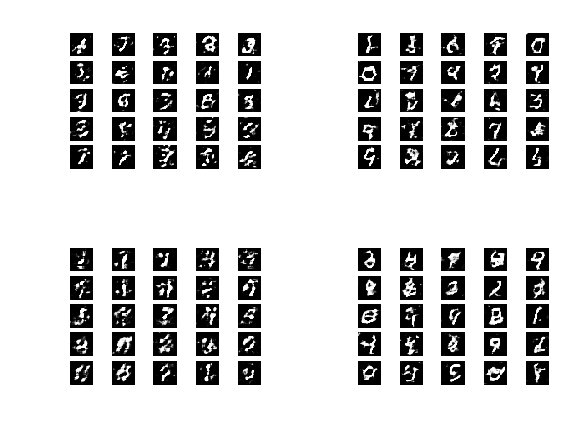

In [21]:
import matplotlib.image as mpimg
sides= 2
img_it= 0
for i in range(0, sides) :
    for j in range(0, sides) :
        img = mpimg.imread(list[img_it])
        plt.subplot(sides, sides, 1 + img_it)
        plt.axis("off")
        img_it +=1
        plt.imshow(img )
        
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()        
        

(-0.5, 575.5, 395.5, -0.5)

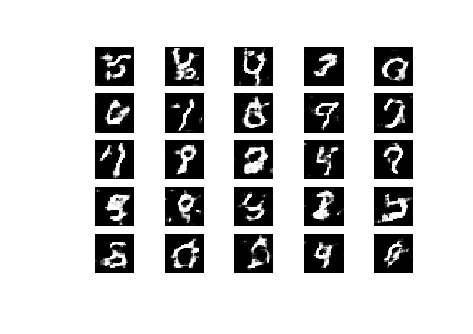

In [25]:
img=mpimg.imread('mnist_3950.png')
imgplot = plt.imshow(img)
plt.axis("off")